In [1]:
import nltk
nltk.download('punkt')

import pickle
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from config import model_config
from copy import copy
from search_utils.Example import Example
from search_utils.Query import Query
from search_utils.Statistics import Statistics
from search_utils.Result import Result
from search_utils.Sentence import Sentence
from search_utils.schedule_words import Edit
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from collections import Iterable

from config import COST_PER_ADDITIONAL_WORD

def clean(s):
    return model_config.tokenizer.clean_up_tokenization(' '.join(Sentence(s).words)).replace(" - ", "-").lower()

def flatten(x):
    return chain.from_iterable([i] if not isinstance(i, Iterable) else i for i in x)


DATASET = "sst-2"
#DATASET = "imdb"

model_config.load(DATASET)

[nltk_data] Downloading package punkt to /Users/christoph/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
09/09/2020 14:07:04 - WARNING - config -   DEVICE=None
09/09/2020 14:07:05 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt from cache at /Users/christoph/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
09/09/2020 14:07:06 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /Users/christoph/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.788fed32bb8481a9b15ce726d41c53d5d5066b04c667e34ce3a7a3826d1573d8
09/09/2020 14:07:06 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures"

09/09/2020 14:07:21 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_layer": 24,
  "n_positions": 1024,
  "n_special": 0,
  "predict_special_tokens": true,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "vocab_size": 50257
}

09/09/2020 14:07:21 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/gpt2-medium-pytorch_model.bin from cache at /Users/christoph/.cache/torch/transfo

In [2]:
hyperparameters = ['data/hyperparameter/0_to_95_on_Tesla T4_imdb.pickle',
                   'data/hyperparameter/100_to_235_on_Tesla P100-PCIE-16GB_imdb.pickle']

sst_files = ['data/sst2/0_to_220_on_Tesla K80_sst-2.pickle',
             'data/sst2/221_to_660_on_Tesla P100-PCIE-16GB_sst-2.pickle',
             'data/sst2/661_to_870_on_Tesla T4_sst-2.pickle',
             'data/sst2/871_to_871_on_Tesla T4_sst-2.pickle']
    
imdb_files = ['data/imdb/0_to_100_on_Tesla T4_H2H2_imdb.pickle',
              'data/imdb/101_to_560_on_Tesla P100-PCIE-16GB_H2H2_imdb.pickle',
              'data/imdb/561_to_855_on_Tesla P100-PCIE-16GB_H2H2_imdb.pickle']


#dataset_files = hyperparameters
#dataset_files = imdb_files
dataset_files = sst_files

calc_ppl = True

data = []
for subfile in dataset_files:
    with open(subfile, 'rb') as f:
        pickle_data = pickle.load(f)
        items = list(pickle_data.items())
        file_ds = items[0][0]
        print(f"reading {subfile}: {len(items[0][1])} items")
        assert file_ds.lower() == DATASET.lower()
        data.extend(items[0][1])

df = []
wanted_order = ["BASE", "MBS", "ST", "MBS+ST"]
max_idx = -1
for i in tqdm(range(len(data))):
#for i in tqdm(range(100)):
    ds_idx, result = data[i]
    max_idx = max(max_idx, ds_idx)
    
    q: Query = result.query
    s: Statistics = result.stats
        
    dct = {
        'idx': i,
        'ds_idx': ds_idx,
        'alg': q.alg(),
        'mini_beam_search' : q.mini_beam_search,
        'split_sentences' : q.allow_splitting,
        'consider_max_words' : q.consider_max_words,
        'top_k': q.consider_top_k,
        'total_duration': s.total_duration.duration,
        'merge_duration': s.merging_duration.duration,
        'find_words_duration': s.find_matching_words_duration.duration,
        'tried_examples': s.tried_examples,
        'tried_sentences': s.tried_sentences,
        'total_sentences': s.tried_sentences,
        'diff_examples': len(result.examples),
        'success': result.success,
        'searched_diff_examples': q.num_needed,
        'original_cls': s.original_classification[1],
        'sentence_length': len(Sentence(clean(result.stats.original_sentence)).words),
        'wanted_cls': q.wanted_cls[1],
    }


    if calc_ppl:
        dct['original_ppl']= Sentence(clean(result.stats.original_sentence)).calc_perplexity()
    
    for i, exs in enumerate(result.examples):
        if calc_ppl:
            dct[f"ex_{i+1}_ppl"] = Sentence(clean(exs[0].sentence)).calc_perplexity()
            dct[f"ex_{i+1}_ppl_diff"] = dct[f"ex_{i+1}_ppl"] - dct['original_ppl']
        dct[f"ex_{i+1}_num_changes"] = len(exs[0].changed_word_indices())
        d = exs[0].changed_word_distances()
        dct[f"ex_{i+1}_sum_changes"] = sum(d)
        dct[f"ex_{i+1}_distance"] = sum([d_i ** 2 for d_i in d]) + COST_PER_ADDITIONAL_WORD * len(d)
        dct[f"ex_{i+1}_cls"] = exs[0].cls[1]
        dct[f"ex_{i+1}_mbs"] = exs[0].used_mini_beam_search()  # only consider these when evaluating mbs
        dct[f"ex_{i+1}_max_pred_ind"] = max(flatten(exs[0].prediction_indices))
        dct[f"ex_{i+1}_max_sched_ind"] = max(flatten(exs[0].schedule_indices))
        dct[f"ex_{i+1}_max_sent_ind"] = max(flatten(exs[0].sentence_indices))

    df.append(dct)

df = pd.DataFrame(df)


reading data/sst2/0_to_220_on_Tesla K80_sst-2_2020-08-13.pickle: 884 items
reading data/sst2/221_to_660_on_Tesla P100-PCIE-16GB_sst-2_2020-08-14.pickle: 1760 items


  0%|          | 0/3488 [00:00<?, ?it/s]

reading data/sst2/661_to_870_on_Tesla T4_sst-2_2020-08-14.pickle: 840 items
reading data/sst2/871_to_871_on_Tesla T4_sst-2_2020-08-14.pickle: 4 items


100%|██████████| 3488/3488 [33:04<00:00,  1.76it/s]


In [48]:
f"Evaluation on the {DATASET} dataset took {df['total_duration'].sum()/60/60} hours"

'Evaluation on the sst-2 dataset took 17.659718537926672 hours'

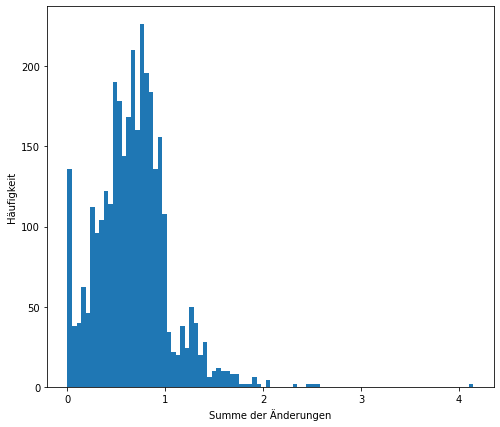

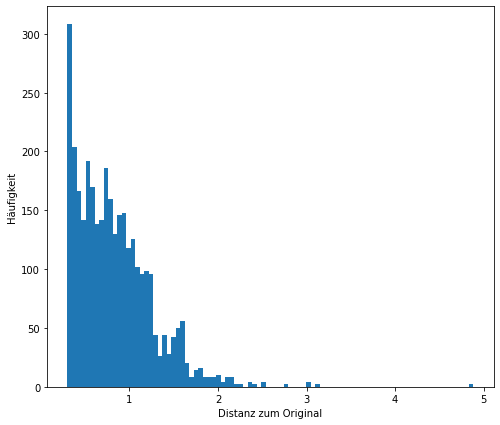

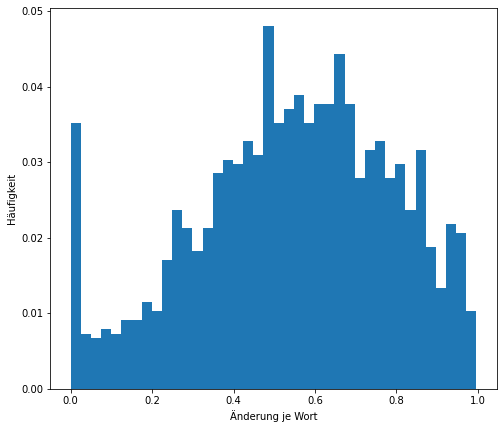

In [51]:
plt.figure(figsize=(8,7))
plt.hist(df["ex_1_sum_changes"], bins=90)
plt.xlabel("Summe der Änderungen")
plt.ylabel("Häufigkeit")
plt.show()

plt.figure(figsize=(8,7))
plt.hist(df["ex_1_distance"], bins=90)
plt.xlabel("Distanz zum Original")
plt.ylabel("Häufigkeit")
plt.show()

cond = df["ex_1_sum_changes"].notnull()

plt.figure(figsize=(8,7))
plt.hist(df[cond]["ex_1_sum_changes"] / df[cond]["ex_1_num_changes"], bins=40, \
         weights=np.ones_like(df[cond]["ex_1_num_changes"]) / len(df[cond]["ex_1_num_changes"]))
plt.xlabel("Änderung je Wort")
plt.ylabel("Häufigkeit")
plt.show()

all


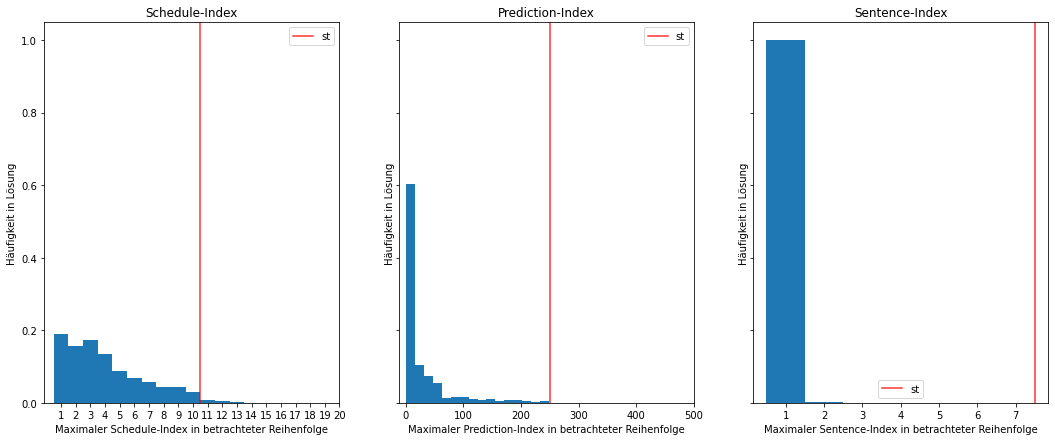

MBS+ST


/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


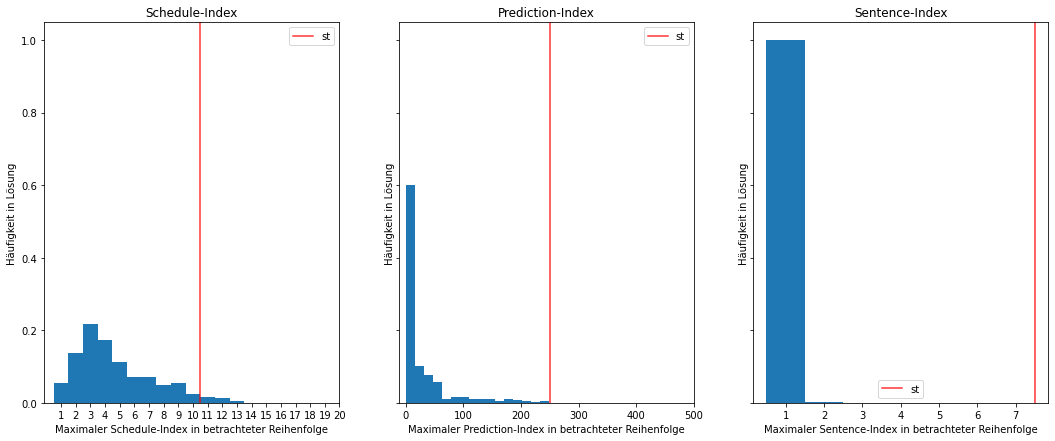

MBS


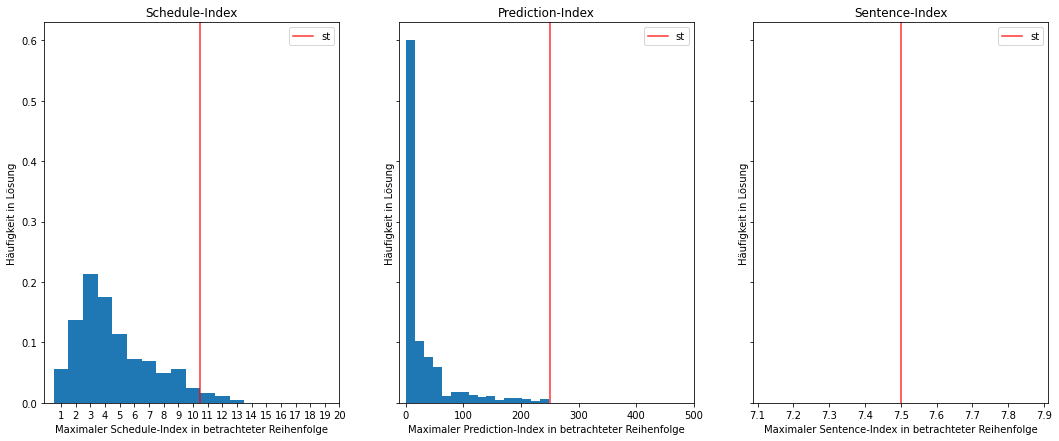

ST


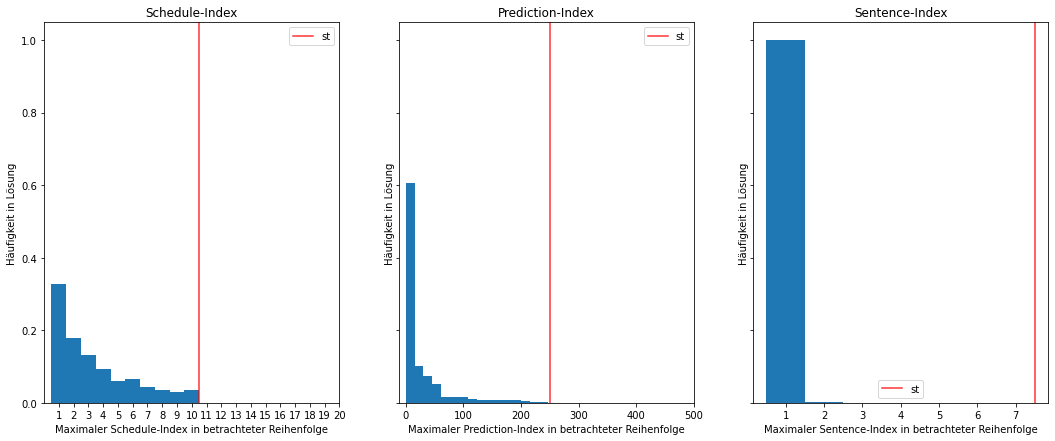

BASE


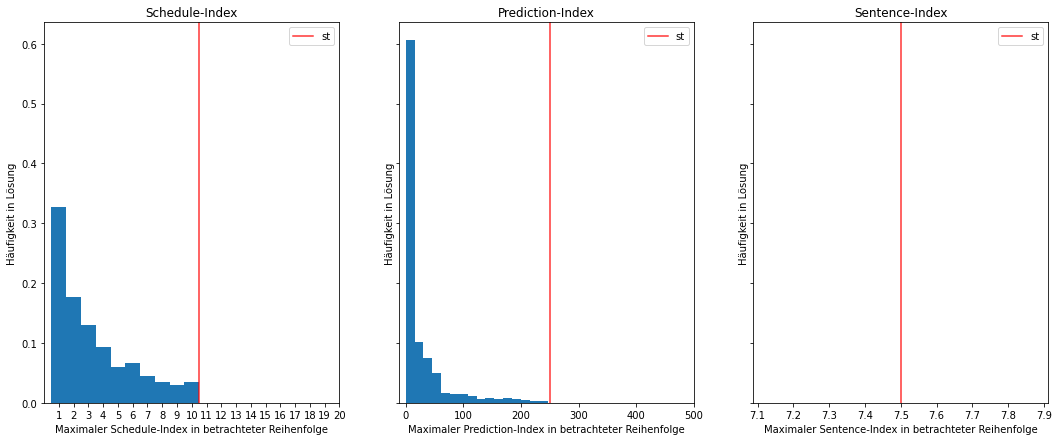

In [54]:
for alg in ["all"] + df["alg"].unique().tolist():
    sub_df = df[df["alg"] == alg] if alg != "all" else df
    print(alg)
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,7), sharey=True)

    ind = sub_df["ex_1_max_sched_ind"].value_counts(normalize=True).sort_index()#.cumsum()
    ax1.bar(ind.index+1, ind, align='center', width=1.0)
    ax1.set_xticks(range(1,26))
    ax1.set_xlim(None, 20)
    ax1.set_title("Schedule-Index")
    ax1.set_xlabel("Maximaler Schedule-Index in betrachteter Reihenfolge")
    ax1.set_ylabel("Häufigkeit in Lösung")
    ax1.axvline(10.5, c="r", alpha=0.8, label="st")
    ax1.legend()

    ax2.hist(sub_df["ex_1_max_pred_ind"], bins=16, 
             weights=np.ones_like(sub_df["ex_1_max_pred_ind"]) / len(sub_df["ex_1_max_pred_ind"]))
    ax2.set_title("Prediction-Index")
    ax2.set_xlabel("Maximaler Prediction-Index in betrachteter Reihenfolge")
    ax2.set_ylabel("Häufigkeit in Lösung")
    ax2.set_xlim(None,500)
    ax2.axvline(250, c="r", alpha=0.8, label="st")
    ax2.legend()

    ind = sub_df[sub_df["split_sentences"] == True]["ex_1_max_sent_ind"].value_counts(normalize=True).sort_index()#.cumsum()
    ax3.bar(ind.index+1, ind, align='center', width=1.0)
    ax3.set_title("Sentence-Index")
    ax3.set_xlabel("Maximaler Sentence-Index in betrachteter Reihenfolge")
    ax3.set_ylabel("Häufigkeit in Lösung")
#    ax3.set_xlim(None, 20)
    ax3.axvline(7.5, c="r", alpha=0.8, label="st")
    ax3.legend()

    # plt.tight_layout()
    if alg == "all":
        plt.savefig("new_resulting_schedule_indices.pdf")
    plt.show()



In [56]:
#print("Duration by algorithm and result")
df["found_none"] = df["diff_examples"] == 0
df["found_one"] = df["diff_examples"] == 1
df["found_two"] = df["diff_examples"] == 2
df["found_three"] = df["diff_examples"] == 3

if DATASET == "sst-2":
    display(df.groupby(["alg"])[["total_duration",
                               "found_none", 
                               "found_one",
                               "found_two","found_three"
                              ]].mean().round(2)) # .to_latex(caption=f"{DATASET} : {max_idx+1} samples"))

    display(df.groupby(["alg"])[["ex_1_ppl_diff",
                               "ex_2_ppl_diff",
                               "ex_3_ppl_diff",
                             ]].mean().round(2)) # .to_latex(caption=f"{DATASET} : {max_idx+1} samples"))
elif DATASET == "imdb":
    display(df.groupby(["alg"])[["total_duration",
                               "found_one",
                               "ex_1_ppl_diff",
                              ]].mean().round(2)) # .to_latex(caption=f"{DATASET} : {max_idx+1} samples"))

,total_duration,found_none,found_one,found_two,found_three
alg,,,,,
BASE,13.80,0.06,0.18,0.23,0.52
MBS,19.86,0.05,0.21,0.24,0.50
MBS+ST,22.66,0.05,0.21,0.24,0.50
ST,16.59,0.06,0.18,0.23,0.52


,ex_1_ppl_diff,ex_2_ppl_diff,ex_3_ppl_diff
alg,,,
BASE,45.56,57.14,49.80
MBS,43.11,54.17,40.66
MBS+ST,43.13,54.16,40.67
ST,45.57,57.16,49.83


In [61]:
ex_num = 3
df[f"ex_{exex}_distance_pw"] = df[f"ex_{ex_num}_sum_changes"] / df[f"ex_{ex_num}_num_changes"]

df.groupby(["alg"])[[f"ex_{ex_num}_num_changes",
                     f"ex_{ex_num}_distance",                           
                     f"ex_{ex_num}_distance_pw"
                    ]].agg(["mean", "std"]).round(2) # .to_latex(caption=f"{DATASET} : {max_idx+1} samples"))

ex_3_num_changes      ex_3_distance      ex_3_distance_pw     
                   mean  std          mean  std             mean  std
alg                                                                  
BASE               1.42 0.59          1.23 0.48             0.74 0.18
MBS                1.79 0.83          1.48 0.64             0.72 0.18
MBS+ST             1.79 0.83          1.48 0.64             0.72 0.18
ST                 1.42 0.59          1.23 0.48             0.74 0.18

In [12]:
#df.groupby(["alg"])[["ex_1_ppl_diff"]].describe().round(2)
      #.to_latex(caption=f"{DATASET} : {max_idx+1} samples"))

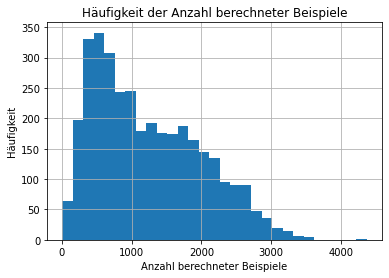

In [66]:
plt.xlabel("Anzahl berechneter Beispiele")
plt.ylabel("Häufigkeit")
plt.title("Häufigkeit der Anzahl berechneter Beispiele")
df["tried_examples"].hist(bins=29)
plt.show()

100%|██████████| 3488/3488 [00:00<00:00, 11960.90it/s]


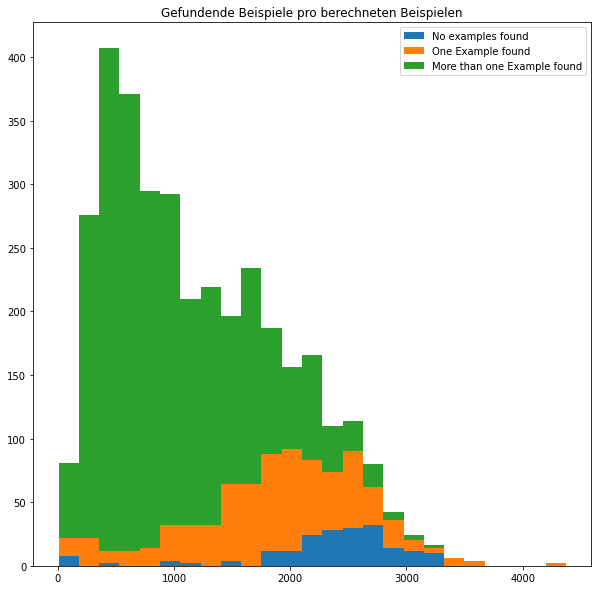

In [67]:
qset = set()
for i in tqdm(range(len(data))):
    ds_idx, result = data[i]
    max_idx = max(max_idx, ds_idx)
    qqq = dict(result.query.__dict__)
    del qqq["wanted_cls"]
    qset.add(str(qqq))

        
zero = df[df["diff_examples"] == 0]
one = df[df["diff_examples"] == 1]
more = df[df["diff_examples"] > 1]

fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

ax1.set_title("Gefundende Beispiele pro berechneten Beispielen")
ax1.hist([zero["tried_examples"], one["tried_examples"], 
          more["tried_examples"]
         ], label=["No examples found", "One Example found", 
                   "More than one Example found"
                  ], bins=25, stacked=True)


ax1.legend()
fig.savefig("blauer_huegel.pdf")
plt.show()


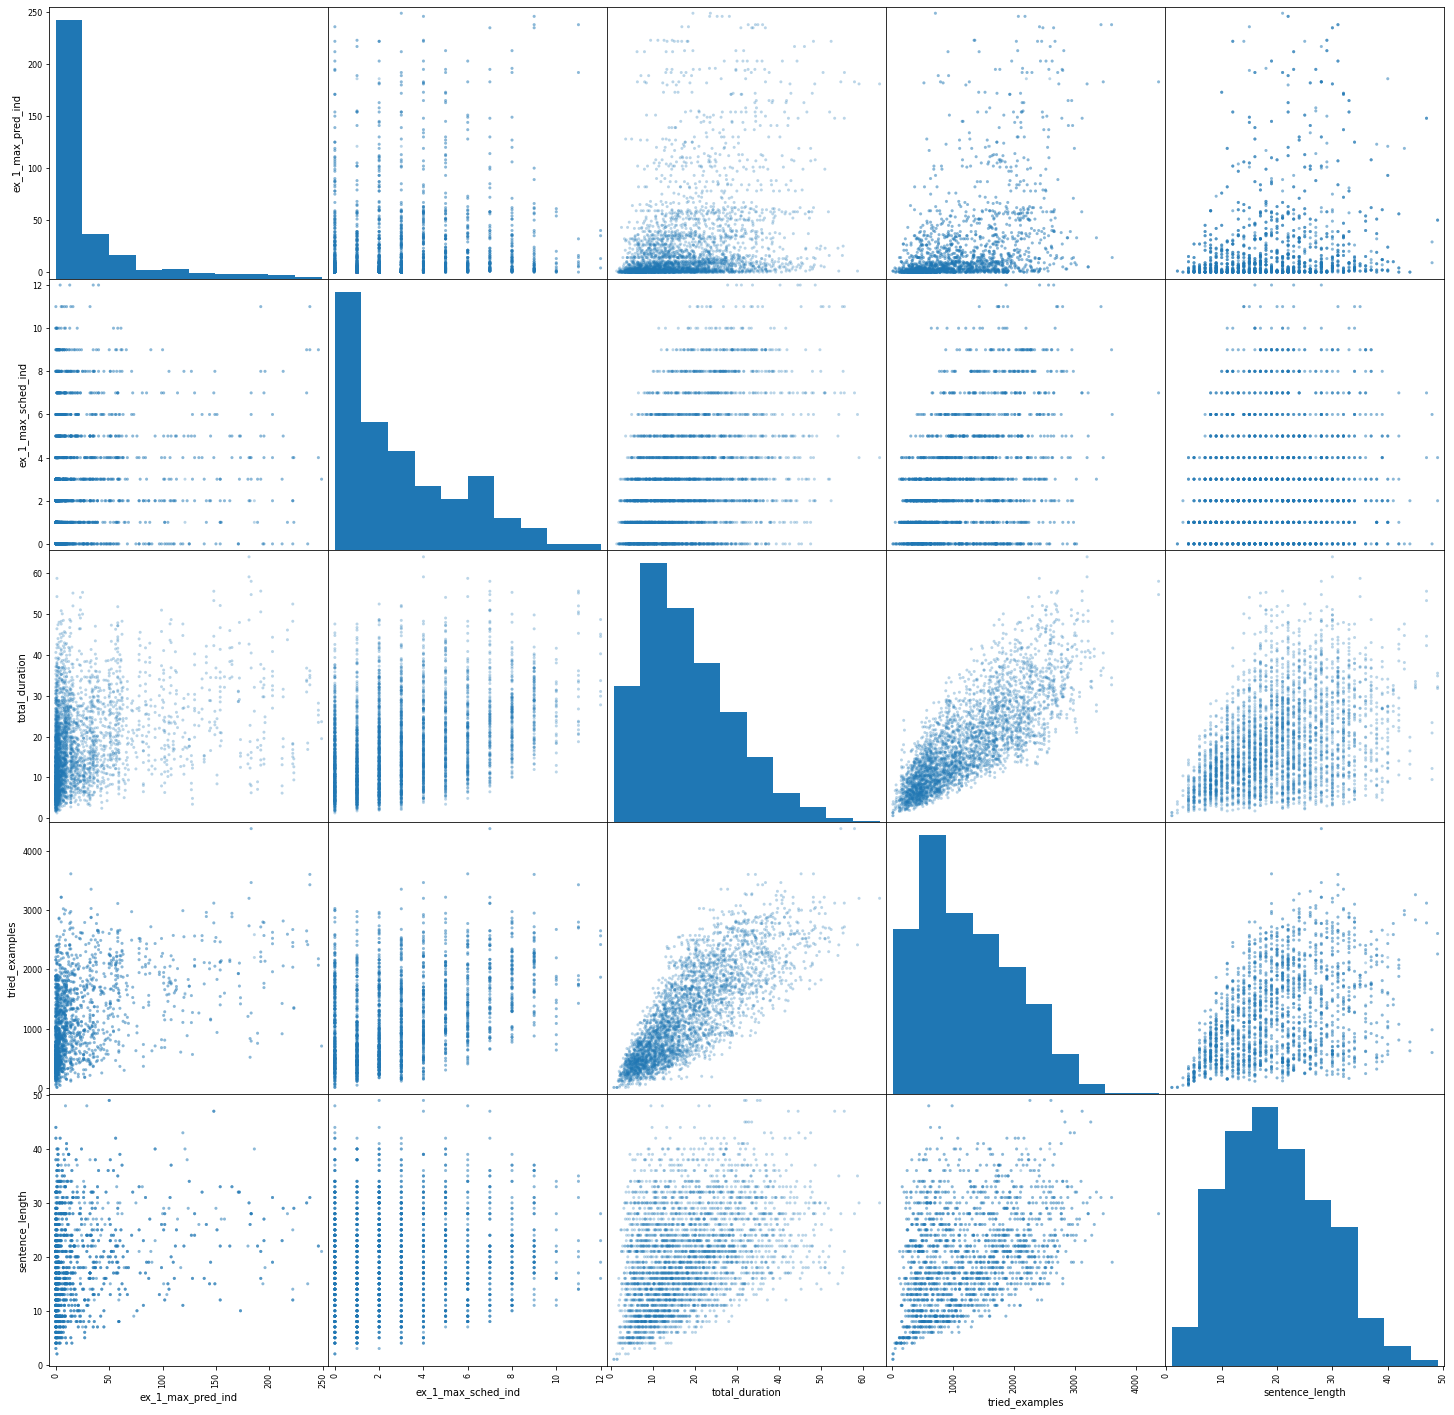

In [69]:
pd.plotting.scatter_matrix(df[["ex_1_max_pred_ind","ex_1_max_sched_ind","total_duration", "tried_examples", "sentence_length"]], alpha=0.3, figsize=(25,25))
plt.show()

In [73]:
print("Duration by success and algorithm variant:")
df.groupby(["alg", "success"])["total_duration"].agg(["mean", "std"])

Duration by success and algorithm variant:


mean   std
alg    success            
BASE   False   19.97  9.22
       True     8.20  4.86
MBS    False   25.33 11.12
       True    14.44  6.95
MBS+ST False   27.90 11.62
       True    17.45  7.63
ST     False   22.49  9.61
       True    11.20  5.45

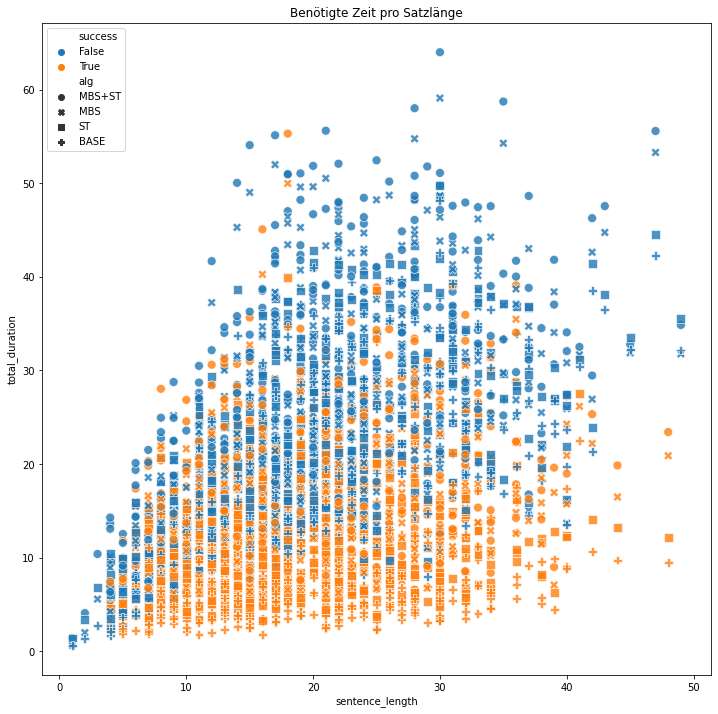

In [74]:
plt.figure(figsize=(12,12))
plt.title("Benötigte Zeit pro Satzlänge")
sns.scatterplot(data=df, x="sentence_length", y="total_duration", hue="success", style="alg", s=80, alpha=0.8)
plt.show()

<AxesSubplot:xlabel='sentence_length', ylabel='total_duration'>

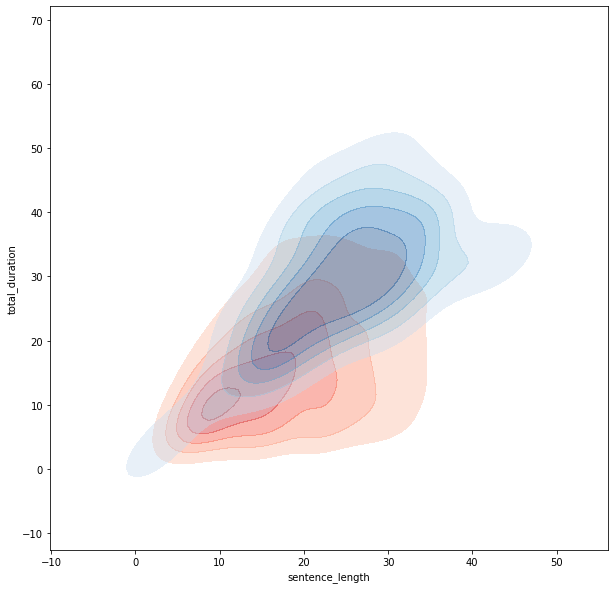

In [75]:
opts = dict(n_levels=5, shade=True, shade_lowest=False, alpha=0.4, legend=True)
plt.figure(figsize=(10,10))
cnd = df["diff_examples"] > 0
sns.kdeplot(df[cnd]["sentence_length"], df[cnd]["total_duration"], label="asd",cmap="Reds", **opts)
cnd = df["diff_examples"] == 0
sns.kdeplot(df[cnd]["sentence_length"], df[cnd]["total_duration"], cmap="Blues", **opts)

In [ ]:
for i in (range(1,4) if DATASET == "sst-2" else [1]):
    display(df[f"ex_{i}_num_changes"].describe())
    plt.figure()
    ind = sub_df[f"ex_{i}_num_changes"].value_counts(normalize=True).sort_index()#.cumsum()
    plt.bar(ind.index, ind, align='center', width=.9)
    plt.show()

In [ ]:
ind = df[f"ex_1_num_changes"].value_counts(normalize=True).sort_index()#.cumsum()
cnd = ind < 0.0271
display(cnd)
out = ind[~cnd]
out[f"{int(min(ind[cnd].index))} bis {int(max(ind[cnd].index))}"] = ind[cnd].sum()
tab = pd.DataFrame({
    "Prozent": out
})
tab["Prozent"] = tab.apply(lambda row: f"{np.round(row['Prozent'] * 100, 2):.2f}%", axis=1)
tab
for nc in range(1, 6):
    change_by_alg = df.groupby("alg")["ex_1_num_changes"]    
    plt.bar(list(change_by_alg.groups.keys()), change_by_alg.mean())

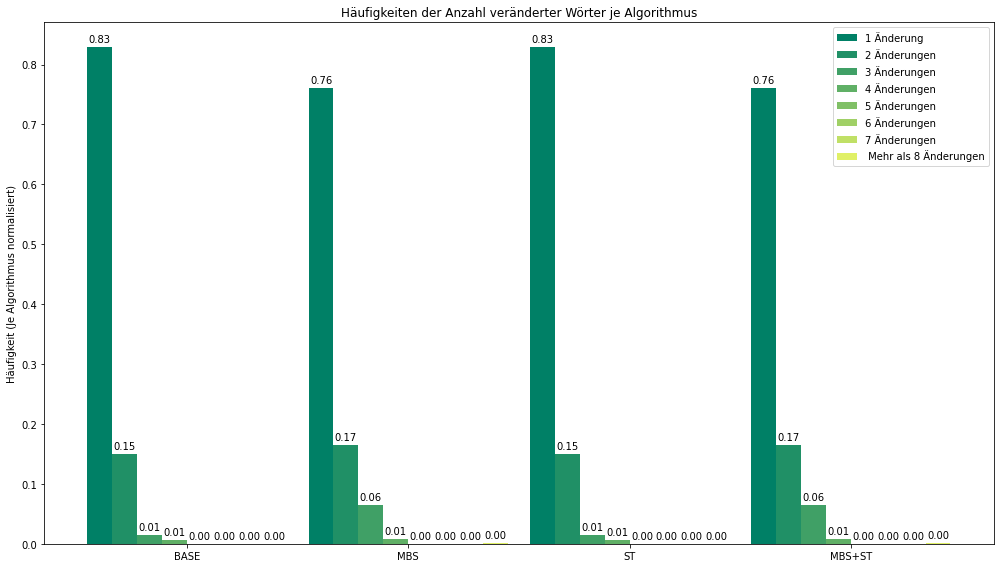

In [77]:
import matplotlib as mpl
import matplotlib.cm as cm


fig, ax = plt.subplots(figsize=(14,8))

labels = wanted_order # ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35]
women_means = [25, 32, 34, 25]

x = np.arange(len(labels))  # the label locations

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


width = .9  # the width of the bars
bars = 8

cmap_scale = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=bars), cmap=cm.summer)

def total_for_alg(a):
    return len(df[(df["alg"] == a) & (df["diff_examples"] != 0)])

for i in range(bars):
    offset = -0.5*width + (width/bars)*i
    num_changes = i+1
    cnd = (df["ex_1_num_changes"] == num_changes) if i != bars-1 else (df["ex_1_num_changes"] >= num_changes)
    if i != bars-1:
        label = f"{num_changes} Änderungen" if num_changes != 1 else f"{num_changes} Änderung"
    else:
        label = f" Mehr als {num_changes} Änderungen"
    plotme = df[cnd].groupby("alg")["ex_1_num_changes"].count()
    plotme = [plotme.get(a, 0)/total_for_alg(a) for a in wanted_order]
    col = cmap_scale.to_rgba(i)
    rects1 = ax.bar(x + offset, plotme, width/bars, label=label, align="edge", color=col)
    autolabel(rects1)

#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Häufigkeit (Je Algorithmus normalisiert)')
ax.set_title('Häufigkeiten der Anzahl veränderter Wörter je Algorithmus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()
plt.savefig("num_changes_per_algorithm_855.pdf")
plt.show()

In [ ]:
pd.options.display.float_format = "{:,.2f}".format

print("Duration based on algorithm")
print("No Examples found:")
display(df[df["diff_examples"] == 0].groupby("alg")["total_duration"].mean())
print("At least one Example found:")
display(df[df["diff_examples"] > 0].groupby("alg")["total_duration"].mean())

print("Duration by Algorithm: No Examples found")
df[df["diff_examples"] == 0].groupby("alg")["total_duration"].mean().plot(kind="bar")
plt.show()

print("Duration by Algorithm: At least one Examples found")
df[df["diff_examples"] > 0].groupby("alg")["total_duration"].mean().plot(kind="bar")
plt.show()

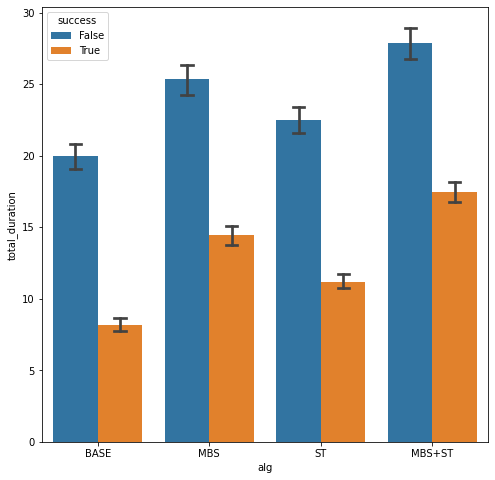

alg     success
BASE    False     19.97
        True       8.20
MBS     False     25.33
        True      14.44
MBS+ST  False     27.90
        True      17.45
ST      False     22.49
        True      11.20
Name: total_duration, dtype: float64

In [79]:
plt.figure(figsize=(8,8))

sns.barplot(data=df, x="alg", y="total_duration", hue="success", 
            order=wanted_order, capsize=0.1, dodge=True)
plt.show()

df.groupby(["alg", "success"])["total_duration"].mean()

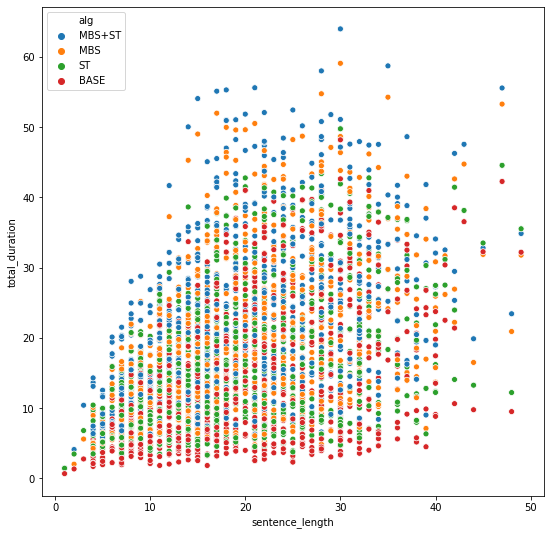

In [81]:
plt.figure(figsize=(9,9))
sns.scatterplot(data=df, x="sentence_length", y="total_duration", hue="alg")
plt.show()

array([[<AxesSubplot:title={'center':'alg_BASE'}>,
        <AxesSubplot:title={'center':'alg_MBS'}>],
       [<AxesSubplot:title={'center':'alg_MBS+ST'}>,
        <AxesSubplot:title={'center':'alg_ST'}>]], dtype=object)

<Figure size 720x720 with 0 Axes>

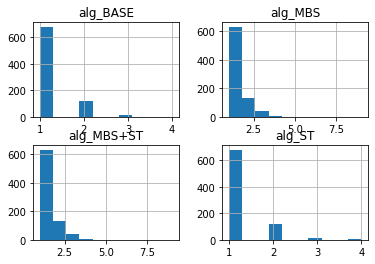

In [82]:
# one-hot per algorithm
cba = pd.get_dummies(df[["ds_idx", "alg", "ex_1_num_changes"]])
# one-hot * changes
cba[cba.filter(regex=("alg_.*")).columns] = cba.filter(regex=("alg_.*")).multiply(cba["ex_1_num_changes"], axis=0)
cba = cba.drop("ex_1_num_changes", axis=1)
# changes per algorithm, 0 if none found
cba = cba.groupby("ds_idx").sum()
all_have_found_one = (cba > 0).all(axis=1)
plt.figure(figsize=(10,10))
cba[all_have_found_one].hist()

# Perplexity

In [88]:
# find outliers
#[df["mini_beam_search"] == False]
by_diff= df[["idx", "ds_idx", "ex_1_ppl_diff"]]\
            .dropna()\
            .drop_duplicates(["ds_idx", "ex_1_ppl_diff"])\
            .sort_values(by=["ex_1_ppl_diff"])
display(by_diff)
best_n = by_diff["idx"].tolist()[:5]
worst_n = by_diff["idx"].tolist()[-5:]
display(best_n + worst_n)

,idx,ds_idx,ex_1_ppl_diff
3408,3408,852,"-3,408.41"
24,24,6,"-1,700.44"
2556,2556,639,-627.65
2776,2776,694,-441.61
572,572,143,-331.26
...,...,...,...
3288,3288,822,"1,147.05"
656,656,164,"1,956.14"
2724,2724,681,"2,234.60"
1968,1968,492,"3,548.24"


[3408, 24, 2556, 2776, 572, 3288, 656, 2724, 1968, 644]

In [89]:
# find most similar explanations
df["ex_1_abs_ppl_diff"] = abs(df["ex_1_ppl_diff"])
by_diff= df[df["mini_beam_search"] == False] \
            [["idx", "ds_idx", "ex_1_abs_ppl_diff"]]\
            .dropna()\
            .drop_duplicates(["ds_idx", "ex_1_abs_ppl_diff"])\
            .sort_values(by=["ex_1_abs_ppl_diff"])
display(by_diff)
same_n = by_diff["idx"][:5].tolist()

,idx,ds_idx,ex_1_abs_ppl_diff
942,942,235,0.03
3298,3298,824,0.04
58,58,14,0.06
2190,2190,547,0.06
310,310,77,0.07
...,...,...,...
658,658,164,"1,956.14"
2726,2726,681,"2,234.60"
3410,3410,852,"3,408.41"
1970,1970,492,"3,548.24"


In [90]:
# print outliers
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
result = ""
for idx in best_n + same_n + worst_n:
    q = data[idx][1].query
    s = data[idx][1].stats.original_sentence
    e = data[idx][1].examples[0][0]
    
    original_same_tok = clean(s)
    counterfactual_ex = clean(e.sentence)
    
    #print(idx)
    #print(f"({Sentence(original_same_tok).calc_perplexity():.2f}) ({data[idx][1].stats.original_classification[1]:.2f}) Original:", original_same_tok)
    #print(f"({Sentence(counterfactual_ex).calc_perplexity():.2f}) ({data[idx][1].examples[0][0].cls[1]:.2f}) Counterf:", counterfactual_ex)
    #print()
    sdf = pd.DataFrame([
    {
        " ": "Original",
        "Perplexity": f"{Sentence(original_same_tok).calc_perplexity():.2f}",
        "Polarität": f"{data[idx][1].stats.original_classification[1]:.2f}",
        "Satz": original_same_tok
    },
    {
        " ": q.alg(),
        "Perplexity": f"{Sentence(counterfactual_ex).calc_perplexity():.2f}", 
        "Polarität": f"{data[idx][1].examples[0][0].cls[1]:.2f}", 
        "Satz": counterfactual_ex
    }])#.to_latex(index=False)
    result += sdf
    display(sdf)
    
#result = result.replace("tabular", "tabularx") \
#        .replace("\\begin{tabularx}", "\\begin{tabularx}{\\textwidth}") \
#        .replace("llll", "cccX")
#print(result)


,,Perplexity,Polarität,Satz
0,Original,5509.69,0.01,part low rent godfather.
1,MBS+ST,2101.28,0.81,not low rent godfather.


,,Perplexity,Polarität,Satz
0,Original,2777.74,0.00,a sometimes tedious film.
1,MBS+ST,1077.30,1.00,a sometimes funny film.


,,Perplexity,Polarität,Satz
0,Original,856.89,0.00,indifferently implausible popcorn programmer of a movie.
1,MBS+ST,229.24,0.96,and the popcorn bowl of a movie.


,,Perplexity,Polarität,Satz
0,Original,1324.63,0.00,no aspirations to social import inform the movie version.
1,MBS+ST,883.02,0.95,his aspirations to social import inform the movie version.


,,Perplexity,Polarität,Satz
0,Original,750.72,0.11,a solid film... but more conscientious than it is truly stirring.
1,MBS+ST,419.47,0.08,a good film... but more conscientious than it is truly stirring.


,,Perplexity,Polarität,Satz
0,Original,24.83,1.00,"whether you like rap music or loathe it, you can't deny either the tragic loss of two young men in the prime of their talent or the power of this movie."
1,ST,24.86,0.01,"whether you like rap music or loathe it, you can't deny either the tragic loss of two young men in the prime of their talent or the tragedy of this movie."


,,Perplexity,Polarität,Satz
0,Original,292.27,0.00,late marriage's stiffness is unlikely to demonstrate the emotional clout to sweep u. s. viewers off their feet.
1,ST,292.23,1.00,late marriage's stiffness is used to demonstrate the emotional clout to sweep u. s. viewers off their feet.


,,Perplexity,Polarität,Satz
0,Original,113.78,0.00,even horror fans will most likely not find what they're seeking with trouble every day ; the movie lacks both thrills and humor.
1,ST,113.71,1.00,even horror fans will most likely not find what they're seeking with trouble every day ; the movie has both thrills and humor.


,,Perplexity,Polarität,Satz
0,Original,22.81,0.01,"the film is based on truth and yet there is something about it that feels incomplete, as if the real story starts just around the corner."
1,ST,22.88,1.00,"the film is based on truth and yet there is something about it that feels surreal, as if the real story starts just around the corner."


,,Perplexity,Polarität,Satz
0,Original,122.80,1.00,the son's room is a triumph of gentility that earns its moments of pathos.
1,ST,122.87,0.01,the son's room is a triumph of gentility that loses its moments of pathos.


,,Perplexity,Polarität,Satz
0,Original,355.44,0.00,it's a buggy drag.
1,MBS+ST,1502.48,0.99,it's no buggy drag.


,,Perplexity,Polarität,Satz
0,Original,740.78,1.00,a woman's pic directed with resonance by ilya chaiken.
1,MBS+ST,2696.92,0.06,a disaster pic directed with resonance by ilya chaiken.


,,Perplexity,Polarität,Satz
0,Original,278.32,0.00,( a ) shapeless blob of desperate entertainment.
1,MBS+ST,2512.91,0.63,( a ) a blob but desperate entertainment.


,,Perplexity,Polarität,Satz
0,Original,141.20,1.00,an exquisitely crafted and acted tale.
1,MBS+ST,3689.44,0.01,an over crafted and acted tale.


,,Perplexity,Polarität,Satz
0,Original,350.66,0.01,not exactly the bees knees
1,MBS+ST,7976.93,0.91,right exactly the bees knees


/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
<ipython-input-92-4e3ec5f33f87>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


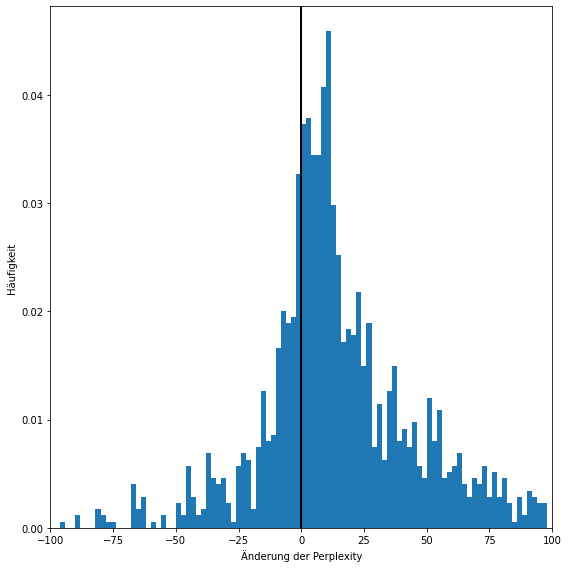

In [92]:
exn = 1
fig, ax = plt.subplots(figsize=(8,8))
r = 100
ax.axvline(0, c="black", alpha=1, linewidth=2)
ax.set_xlabel("Änderung der Perplexity")
ax.set_ylabel("Häufigkeit")
ax.hist(df[f"ex_{exn}_ppl_diff"], bins=100, range=(-r,r), weights=np.ones_like(df[f"ex_{exn}_ppl_diff"]) / len(df[f"ex_{exn}_ppl_diff"]))
ax.set_xlim(-r,r)
fig.tight_layout()
fig.show()
fig.savefig("average_perplexity_diff_medium.pdf")

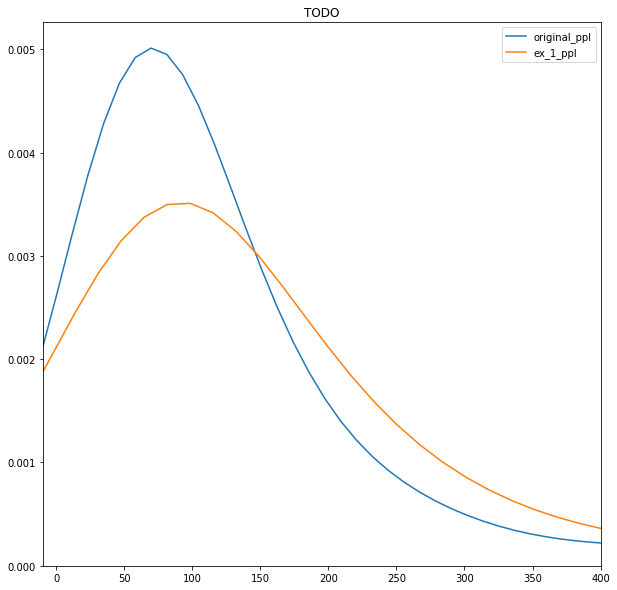

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
sns.kdeplot(df["original_ppl"], gridsize=500)
sns.kdeplot(df["ex_1_ppl"], gridsize=500)
#sns.kdeplot(df["ex_2_ppl"], gridsize=500)
#sns.kdeplot(df["ex_3_ppl"], gridsize=500)
ax.set_xlim(-10, 400)
ax.set_title('Perplexity')
plt.show()

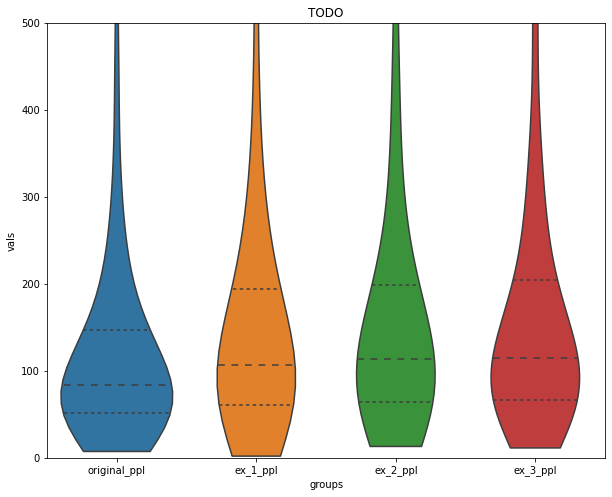

In [94]:
fig, ax = plt.subplots(figsize=(10,8))
dfvp = df[["original_ppl","ex_1_ppl","ex_2_ppl","ex_3_ppl"]].melt(var_name='groups', value_name='vals')
ax = sns.violinplot(x="groups", y="vals", data=dfvp, gridsize=400, inner="quartile", cut=0)
ax.set_title('Perplexity')
ax.set_ylim(0, 500)
plt.show()

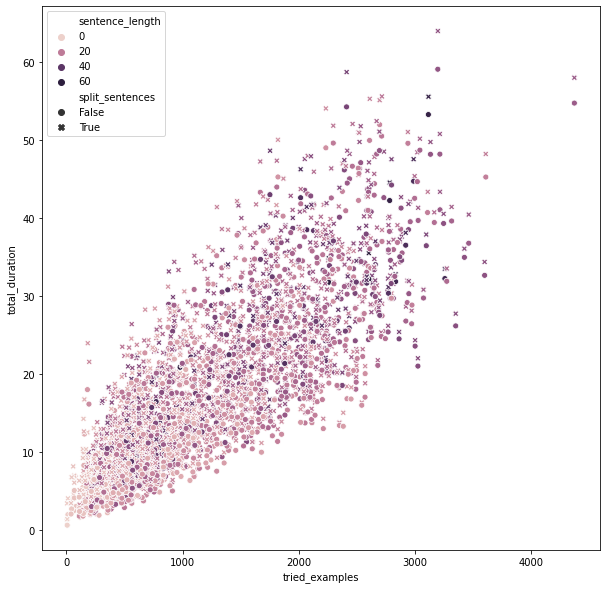

In [40]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="tried_examples", y="total_duration", hue="sentence_length",  style="split_sentences")
plt.show()

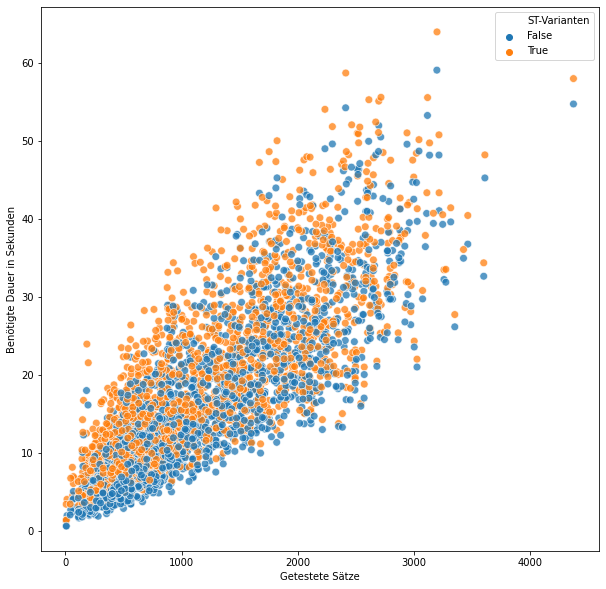

In [101]:
plt.figure(figsize=(10,10))
plot_df = df[["tried_examples", "total_duration", "split_sentences"]]
plot_df = plot_df.rename(columns={"split_sentences": "ST-Varianten"})
ax = sns.scatterplot(data=plot_df, alpha=0.75, x="tried_examples", y="total_duration", hue="ST-Varianten", s=60)
ax.set(xlabel='Getestete Sätze', ylabel='Benötigte Dauer in Sekunden')
plt.show()